In [1]:
# import the libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
%matplotlib inline

## Lendo o dataset

In [2]:
df0 = pd.read_csv('Bitcoin_tweets.csv')
df0.info()

/home/ffreller/.conda/envs/teste1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (4,5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830476 entries, 0 to 2830475
Data columns (total 13 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_name         object
 1   user_location     object
 2   user_description  object
 3   user_created      object
 4   user_followers    object
 5   user_friends      object
 6   user_favourites   object
 7   user_verified     object
 8   date              object
 9   text              object
 10  hashtags          object
 11  source            object
 12  is_retweet        object
dtypes: object(13)
memory usage: 280.7+ MB


In [3]:
# Ficar apenas com a coluna com o conteúdo do tweet e sua data
df1 = df0[['text', 'date']].copy()

# Dropando linhas sem informação
df1.dropna(subset=["text"], inplace=True)

## Limpando o texto

In [4]:
# Função para limpar o texto do tweet
def clean_text(txt):
    txt = re.sub('#', '', txt) # remove simbolo '#'
    txt = re.sub('@[A-Za-z0-9]+', '', txt) # remove qualquer string que começa com '@' (menções)
    txt = re.sub('RT[\s]+', '', txt) # remove indicador de retweet
    txt = re.sub('\\n', '', txt) # tira '\n' do texto
    txt = re.sub('https?:\/\/\S+', '', txt) # tira links
    return txt        

In [5]:
df1['cleaned_text'] = df1['text'].apply(clean_text)

## Polaridade e subjetividade

In [6]:
%%time
#Criando coluna com a subjetividade do tweet
df1['subjetity'] = df1['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

#Criando coluna com a polaridade do tweet
df1['polarity'] = df1['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

CPU times: user 14min 41s, sys: 328 ms, total: 14min 41s
Wall time: 14min 41s


In [7]:
# Salvando para não precisar rodas as funções acima, que demoram, toda vez que rodar o notebook
df1.to_pickle('sentiment_dataset.pkl')

<AxesSubplot:xlabel='polarity', ylabel='subjetity'>

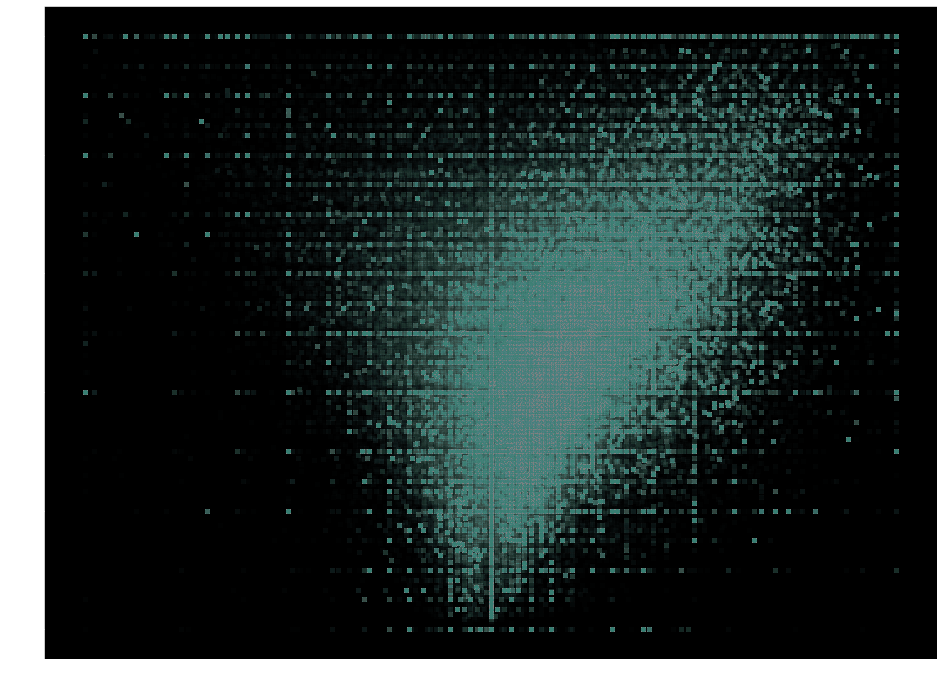

In [8]:
# Gráfico de polaridade vs subjetividade
plt.figure(figsize=(16,12))
sns.scatterplot(x='polarity', y='subjetity', data=df1, alpha=0.01)

Olhando o gráfico de polaridade vs subjetividade, percebe-se que há uma correlação positiva entre os dois.

### Sentimento a partir da polaridade

In [9]:
#Função para imputar sentiment negativo, neutro e positivo a partir da polaridade do tweet
def analyse_polarity(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df1['sentiment'] = df1['polarity'].apply(analyse_polarity)

Positive    49.30%
Neutral     39.58%
Negative    11.12%
Name: sentiment, dtype: object

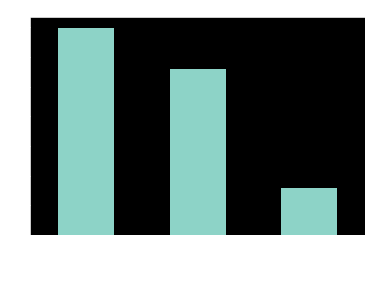

In [10]:
df1['sentiment'].value_counts().plot(kind='bar')
df1['sentiment'].value_counts(1).map('{:.2%}'.format)

De acordo com a análise, quase 50% dos tweets sobre bitcoin foram positivos. Os negativos respondem por pouco mais de 11%

## Nuvem de palavras

(-0.5, 799.5, 399.5, -0.5)

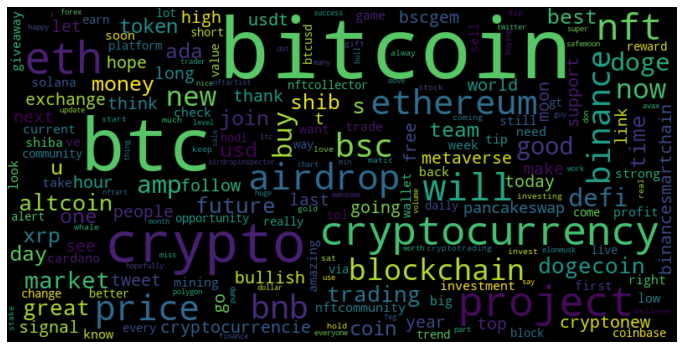

In [11]:
# Nuvem de palavras
all_words = ' '.join([text.lower() for text in df1['cleaned_text']])
wc = WordCloud(max_font_size=100, width=800, height=400, random_state=42, collocations=False).generate(all_words)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

Na núvem de palavras acima, vemos que os tweets sobre bitcoin trazem também algumas outras palavras com frequência. Ganharam destaques: o indicador de bitcoin no mercado ('btc'); a tecnologia por trás do bitcoin (blockchain); referências a criptomoedas (crypto, cryptocurrency); outras moedas (BTH) e outras aplicações de blockchain(nft); além de termos associados a sua venda e compra (buy, sell, market, signal, price, money)

## Sentimento ao longo do tempo

In [12]:
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df1['day'] = pd.to_datetime(df1['date'].dt.date)
df1

,text,date,cleaned_text,subjetity,polarity,sentiment,day
0,Blue Ridge Bank shares halted by NYSE after #b...,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after bi...,0.100000,0.000000,Neutral,2021-02-10
1,"😎 Today, that's this #Thursday, we will do a ""...",2021-02-10 23:58:48,"😎 Today, that's this Thursday, we will do a ""🎬...",0.000000,0.000000,Neutral,2021-02-10
2,"Guys evening, I have read this article about B...",2021-02-10 23:54:48,"Guys evening, I have read this article about B...",0.000000,0.000000,Neutral,2021-02-10
3,$BTC A big chance in a billion! Price: \487264...,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,0.100000,0.000000,Neutral,2021-02-10
4,This network is secured by 9 508 nodes as of t...,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,0.100000,0.000000,Neutral,2021-02-10
...,...,...,...,...,...,...,...
2830471,"@SpaceBirdDefi very good project, don't miss i...",2022-04-13 11:49:15,"very good project, don't miss it friends, let...",0.780000,0.910000,Positive,2022-04-13
2830472,"You became 8.5% poorer, if you held #fiat.\n#S...",2022-04-13 11:49:15,"You became 8.5% poorer, if you held fiat.SEMAN...",0.000000,0.000000,Neutral,2022-04-13
2830473,@YoungDeanz @Vikingobitcoin2 My time preferenc...,2022-04-13 11:49:11,My time preference is of no consequence. Th...,0.576531,0.145578,Positive,2022-04-13
2830474,Legacy markets open flat? #bitcoin was flat?\n...,2022-04-13 11:49:09,Legacy markets open flat? bitcoin was flat?Off...,0.468750,0.118750,Positive,2022-04-13
